In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Path to the zip file on Google Drive
zip_path = '/content/drive/MyDrive/archive.zip'  # Change to your actual file path

# Unzip the dataset
unzip_dir = '/content/MURA'  # Destination folder to unzip to
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print(f"Dataset unzipped to: {unzip_dir}")

Dataset unzipped to: /content/MURA


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# Paths to CSV files
train_img_csv = "/content/MURA/MURA-v1.1/MURA-v1.1/train_image_paths.csv"
valid_img_csv = "/content/MURA/MURA-v1.1/MURA-v1.1/valid_image_paths.csv"
train_study_csv = "/content/MURA/MURA-v1.1/MURA-v1.1/train_labeled_studies.csv"
valid_study_csv = "/content/MURA/MURA-v1.1/MURA-v1.1/valid_labeled_studies.csv"

# Read CSV files
train_paths = pd.read_csv(train_img_csv, header=None)
valid_paths = pd.read_csv(valid_img_csv, header=None)

# Convert labels from study-level to image-level
def get_label_from_path(path):
    return 1 if "positive" in path else 0

# Apply label extraction
train_paths["label"] = train_paths[0].apply(get_label_from_path)
valid_paths["label"] = valid_paths[0].apply(get_label_from_path)

# Convert paths to full paths
train_paths[0] = train_paths[0].apply(lambda x: os.path.join("/content/MURA/MURA-v1.1", x))
valid_paths[0] = valid_paths[0].apply(lambda x: os.path.join("/content/MURA/MURA-v1.1", x))



class MURADataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx, 0]
        label = self.df.iloc[idx, 1]

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

# Define image transformations
img_size = 224
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

valid_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Create datasets
train_dataset = MURADataset(train_paths, transform=train_transform)
valid_dataset = MURADataset(valid_paths, transform=valid_transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

train


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.models import ResNet50_Weights

# Load pre-trained ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Freeze feature extractor layers
for param in model.parameters():
    param.requires_grad = False

# Modify classifier (final layer) for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Binary classification (sigmoid activation will be applied later)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Used for binary classification
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)  # Train only the classifier layer

num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)  # Ensure labels are float

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = torch.round(torch.sigmoid(outputs))  # Convert logits to probabilities
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_acc:.4f}")

print("Training completed!")


Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 113MB/s]


Epoch [1/10], Loss: 0.6255, Accuracy: 0.6541
Epoch [2/10], Loss: 0.5902, Accuracy: 0.6942
Epoch [3/10], Loss: 0.5785, Accuracy: 0.7054
Epoch [4/10], Loss: 0.5720, Accuracy: 0.7092
Epoch [5/10], Loss: 0.5680, Accuracy: 0.7142
Epoch [6/10], Loss: 0.5641, Accuracy: 0.7140
Epoch [7/10], Loss: 0.5631, Accuracy: 0.7159
Epoch [8/10], Loss: 0.5623, Accuracy: 0.7154
Epoch [9/10], Loss: 0.5589, Accuracy: 0.7172
Epoch [10/10], Loss: 0.5580, Accuracy: 0.7193
Training completed!


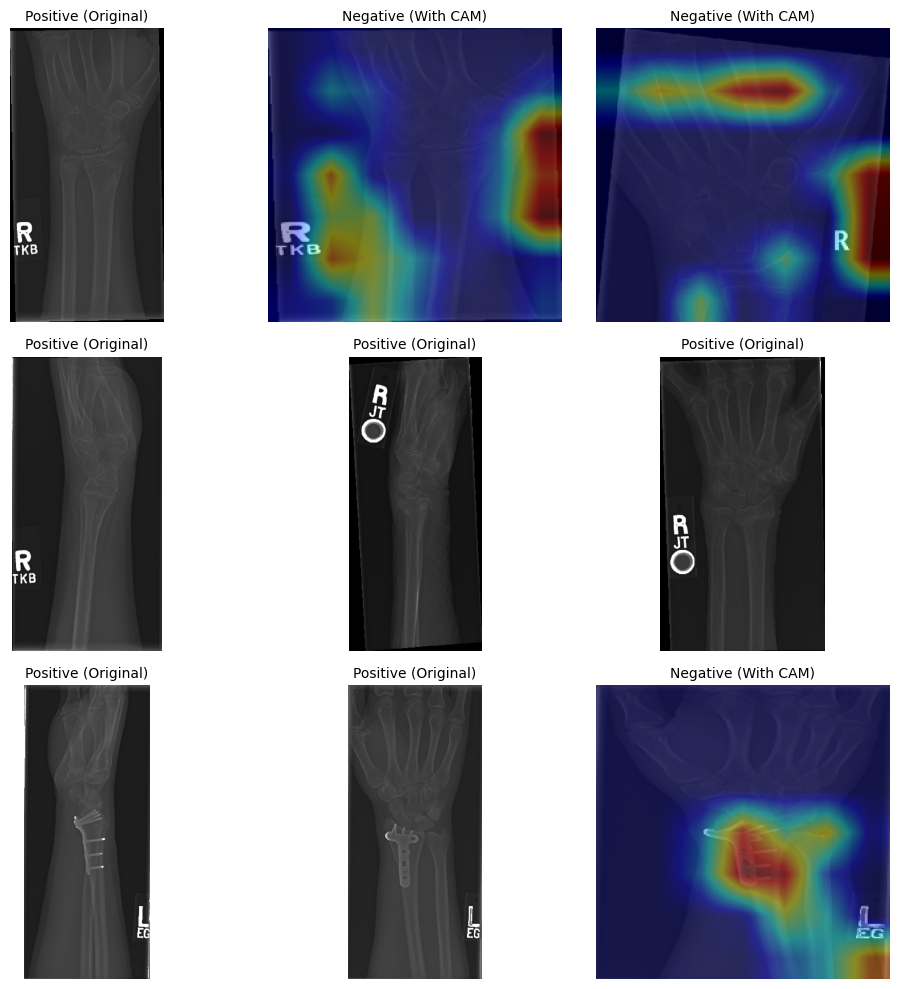

In [ ]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

# Define function to compute CAM
def compute_cam(model, img_tensor, layer_name="layer4"):
    model.eval()

    feature_maps = None
    def hook_fn(module, input, output):
        nonlocal feature_maps
        feature_maps = output

    # Hook the selected layer
    layer = dict(model.named_modules())[layer_name]
    handle = layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        output = model(img_tensor)

    handle.remove()

    # Get predicted class
    predicted_class = torch.round(torch.sigmoid(output)).item()

    if predicted_class == 1:  # Positive case, return original image
        return None, predicted_class

    # Get weight of final layer
    weights = model.fc.weight.detach().cpu().numpy()

    # Compute CAM
    cam = np.zeros(feature_maps.shape[2:], dtype=np.float32)
    for i in range(weights.shape[1]):
        cam += weights[0, i] * feature_maps[0, i].detach().cpu().numpy()

    # Normalize CAM
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    cam = np.uint8(255 * cam)
    cam = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

    return heatmap, predicted_class

# Load first 9 validation images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(9):
    img_path = valid_paths.iloc[i, 0]
    img = Image.open(img_path).convert("RGB")

    # Preprocess image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Get CAM or original image
    cam, predicted_class = compute_cam(model, img_tensor)

    # Convert original image for visualization
    img_np = np.array(img.resize((224, 224)))
    img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

    if cam is not None:  # If negative, apply CAM
        superimposed_img = cv2.addWeighted(img_np, 0.6, cam, 0.4, 0)
        axes[i // 3, i % 3].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
        axes[i // 3, i % 3].set_title("Negative (With CAM)", fontsize=10)
    else:  # If positive, show original
        axes[i // 3, i % 3].imshow(img)
        axes[i // 3, i % 3].set_title("Positive (Original)", fontsize=10)

    axes[i // 3, i % 3].axis("off")

plt.tight_layout()
plt.show()


### try anotheer model efficient Net - B3

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

# ================================
# DEVICE CONFIGURATION
# ================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ================================
# MODEL DEFINITION (EfficientNet-B3)
# ================================
model = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)

# Modify the final layer for binary classification (positive or negative)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 1)  # Single output neuron for binary classification
model = model.to(device)

# ================================
# LOSS FUNCTION & OPTIMIZER
# ================================
criterion = nn.BCEWithLogitsLoss()  # Binary classification with sigmoid activation
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# ================================
# TRAINING LOOP
# ================================
num_epochs = 10
print("Starting Training...")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()  # Ensure labels are float

        optimizer.zero_grad()
        outputs = model(images)  # Logits output
        loss = criterion(outputs, labels.unsqueeze(1))  # Binary classification loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = torch.sigmoid(outputs) > 0.5  # Convert logits to probabilities and classify
        correct += (predicted == labels.unsqueeze(1)).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total  # Accuracy for binary classification
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

print("Training Completed!")


Using device: cuda
Starting Training...
Epoch [1/10], Loss: 0.4857, Accuracy: 0.7742
Epoch [2/10], Loss: 0.4031, Accuracy: 0.8270
Epoch [3/10], Loss: 0.3556, Accuracy: 0.8520
Epoch [4/10], Loss: 0.3082, Accuracy: 0.8735
Epoch [5/10], Loss: 0.2594, Accuracy: 0.8945
Epoch [6/10], Loss: 0.2131, Accuracy: 0.9145
Epoch [7/10], Loss: 0.1793, Accuracy: 0.9294
Epoch [8/10], Loss: 0.1485, Accuracy: 0.9406
Epoch [9/10], Loss: 0.1281, Accuracy: 0.9510
Epoch [10/10], Loss: 0.1049, Accuracy: 0.9592
Training Completed!


Visualizing Training Dataset:


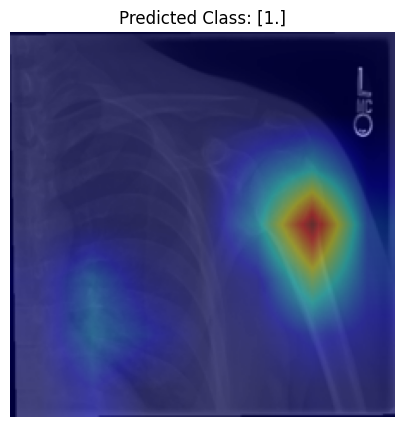

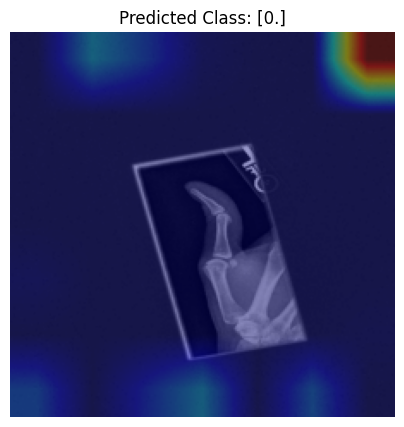

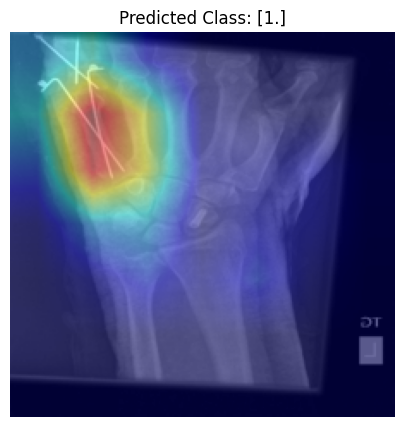

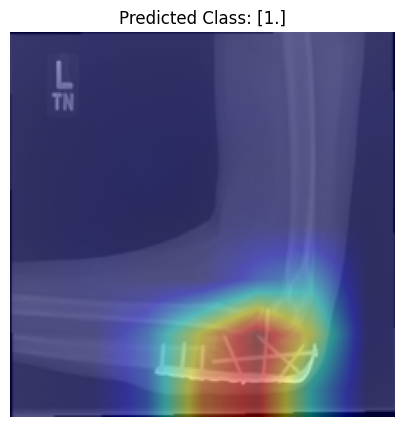

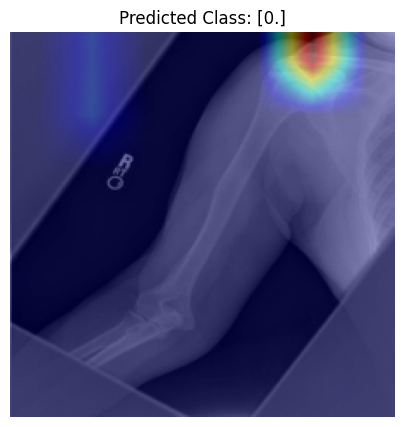

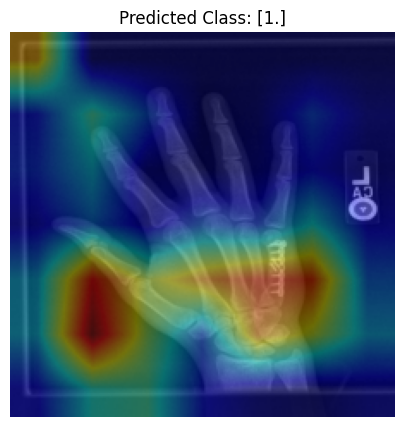

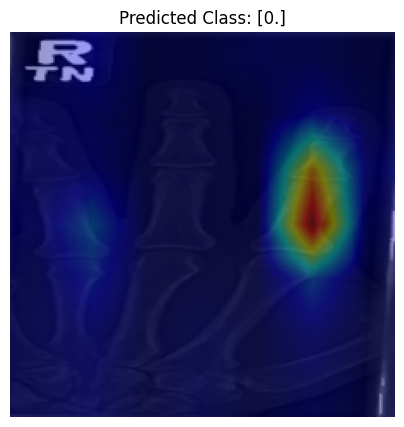

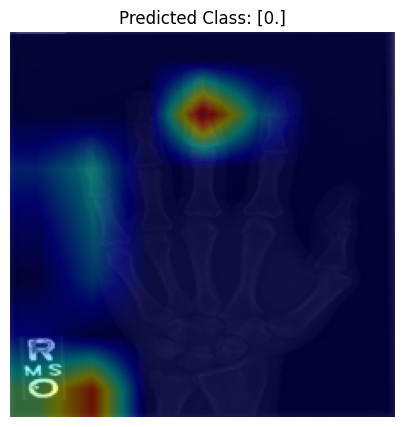

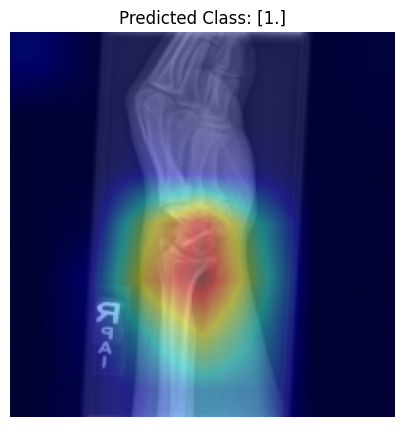

Visualizing Validation Dataset:


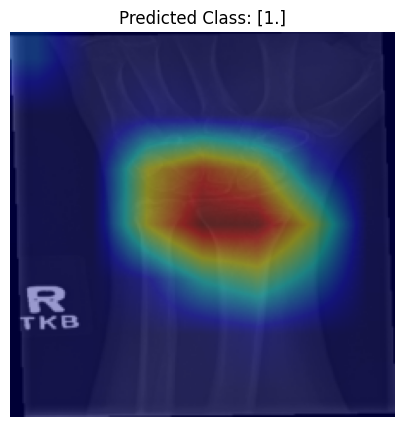

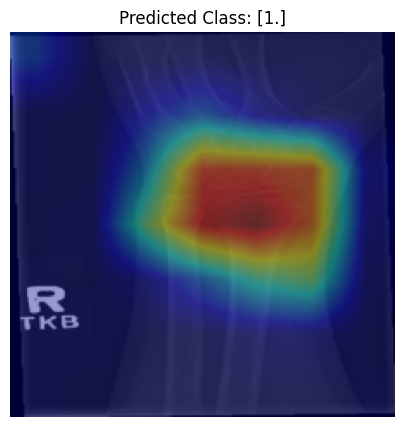

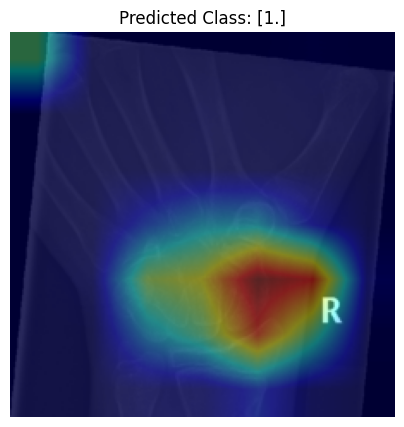

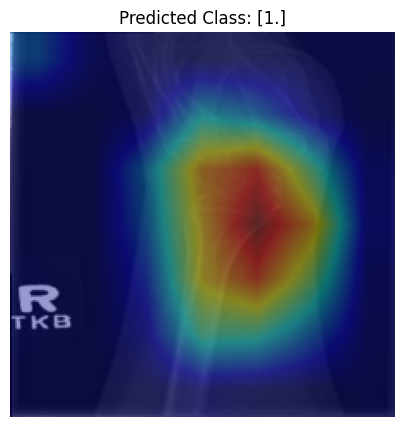

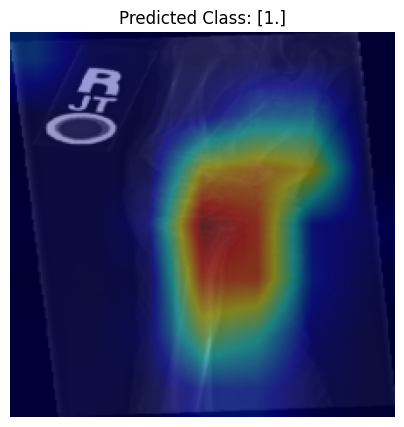

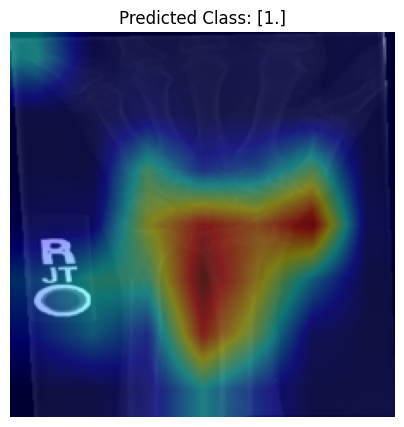

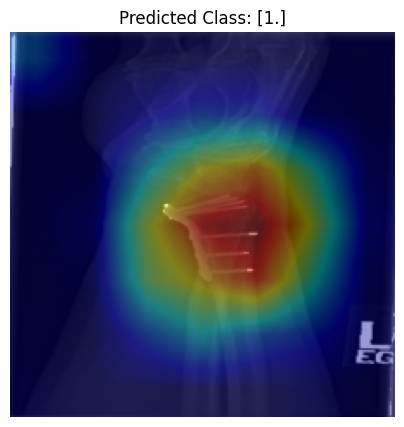

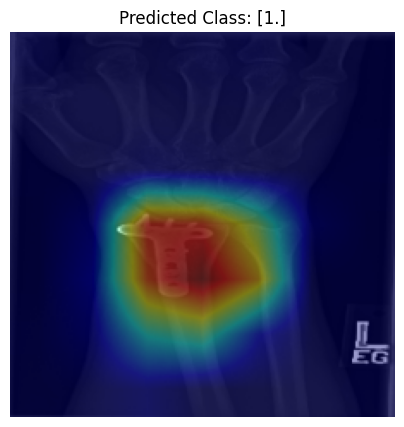

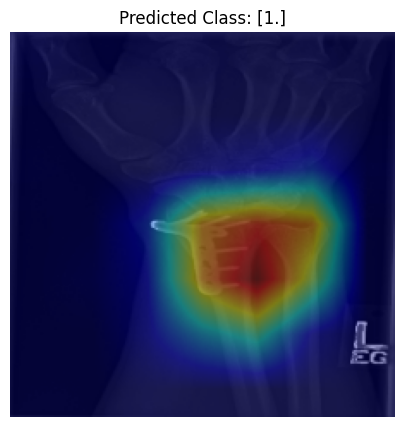

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
from PIL import Image
from torchvision import transforms

def compute_cam(model, img_tensor, layer_name="features.8"):
    model.eval()

    feature_maps = None
    def hook_fn(module, input, output):
        nonlocal feature_maps
        feature_maps = output

    # Hook into the specified layer
    layer = dict(model.named_modules())[layer_name]
    handle = layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        output = model(img_tensor)

    handle.remove()

    # Get predicted class for the entire batch
    predicted_classes = torch.round(torch.sigmoid(output)).cpu().numpy()

    # Initialize CAM for all images in the batch
    cams = []
    for i in range(predicted_classes.shape[0]):  # Iterate over the batch
        predicted_class = predicted_classes[i]

        # Get the weights from the final classifier layer
        weights = model.classifier[1].weight.detach().cpu().numpy().flatten()

        # Initialize the CAM with zeros
        cam = np.zeros(feature_maps.shape[2:], dtype=np.float32)

        # Compute the weighted sum of the feature maps
        for j in range(feature_maps.shape[1]):  # Iterate over channels
            cam += weights[j] * feature_maps[i, j].detach().cpu().numpy()

        # Normalize the CAM
        cam = np.maximum(cam, 0)
        cam = cam / np.max(cam)
        cam = np.uint8(255 * cam)
        cam = cv2.resize(cam, (224, 224))
        heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

        cams.append((heatmap, predicted_class))

    return cams



def visualize_images_with_cam(model, dataset_loader, device, num_images=9):
    model.eval()
    images_shown = 0

    # Iterate over the dataset
    for images, labels in dataset_loader:
        images, labels = images.to(device), labels.to(device)

        # Get CAMs and predicted classes for the batch
        cams = compute_cam(model, images)

        for i in range(len(cams)):
            cam, predicted_class = cams[i]

            # Convert the original image for visualization
            img = images[i].cpu().numpy().transpose((1, 2, 0))
            img = (img - img.min()) / (img.max() - img.min())  # Normalize image for display

            # Superimpose the CAM on the original image
            # Superimpose the CAM on the original image
            img = (img * 255).astype(np.uint8)  # Convert the normalized image back to uint8
            superimposed_img = cv2.addWeighted(img, 0.6, cam, 0.4, 0)

            # Display the image with CAM
            plt.figure(figsize=(5, 5))
            plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
            plt.title(f"Predicted Class: {predicted_class}")
            plt.axis("off")
            plt.show()

            images_shown += 1
            if images_shown >= num_images:
                return

# Visualize the first 9 images from the training dataset
print("Visualizing Training Dataset:")
visualize_images_with_cam(model, train_loader, device)

# Visualize the first 9 images from the validation dataset
print("Visualizing Validation Dataset:")
visualize_images_with_cam(model, valid_loader, device)


try the gradCAM, maybe better than the CAM


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

# ================================
# DEVICE CONFIGURATION
# ================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ================================
# MODEL DEFINITION (EfficientNet-B3)
# ================================
model = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 1)  # Binary classification
model = model.to(device)

# ================================
# LOSS FUNCTION & OPTIMIZER
# ================================
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# ================================
# TRAINING LOOP WITH VALIDATION & MODEL SAVING
# ================================
num_epochs = 10
best_val_loss = float("inf")  # Track the best validation loss

print("Starting Training...")

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    total_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()  # Ensure labels are float

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = torch.sigmoid(outputs) > 0.5
        correct += (predicted == labels.unsqueeze(1)).sum().item()
        total += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = correct / total

    # Validation Phase
    model.eval()
    val_loss = 0.0
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device).float()

            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1))

            val_loss += loss.item()
            predicted = torch.sigmoid(outputs) > 0.5
            val_correct += (predicted == labels.unsqueeze(1)).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(valid_loader)
    val_accuracy = val_correct / val_total

    # Save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"✅ Model saved (Epoch {epoch+1}) with Val Loss: {avg_val_loss:.4f}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

print("Training Completed! Best model saved as 'best_model.pth'")


Using device: cuda
Starting Training...
✅ Model saved (Epoch 1) with Val Loss: 0.4329
Epoch [1/10], Train Loss: 0.4866, Train Acc: 0.7744, Val Loss: 0.4329, Val Acc: 0.8120
✅ Model saved (Epoch 2) with Val Loss: 0.4220
Epoch [2/10], Train Loss: 0.4060, Train Acc: 0.8254, Val Loss: 0.4220, Val Acc: 0.8195
Epoch [3/10], Train Loss: 0.3595, Train Acc: 0.8486, Val Loss: 0.4331, Val Acc: 0.8189
Epoch [4/10], Train Loss: 0.3113, Train Acc: 0.8701, Val Loss: 0.4570, Val Acc: 0.8226
Epoch [5/10], Train Loss: 0.2597, Train Acc: 0.8928, Val Loss: 0.5097, Val Acc: 0.8161
Epoch [6/10], Train Loss: 0.2165, Train Acc: 0.9127, Val Loss: 0.5610, Val Acc: 0.8048
Epoch [7/10], Train Loss: 0.1787, Train Acc: 0.9291, Val Loss: 0.6063, Val Acc: 0.8064
Epoch [8/10], Train Loss: 0.1501, Train Acc: 0.9410, Val Loss: 0.6544, Val Acc: 0.8023
Epoch [9/10], Train Loss: 0.1277, Train Acc: 0.9514, Val Loss: 0.7381, Val Acc: 0.7989
Epoch [10/10], Train Loss: 0.1084, Train Acc: 0.9598, Val Loss: 0.7795, Val Acc: 0.80

tradition CAm

Visualizing Training Dataset:


<ipython-input-8-ab683b940527>:45: RuntimeWarning: invalid value encountered in divide
  cam = cam / np.max(cam)
<ipython-input-8-ab683b940527>:46: RuntimeWarning: invalid value encountered in cast
  cam = np.uint8(255 * cam)


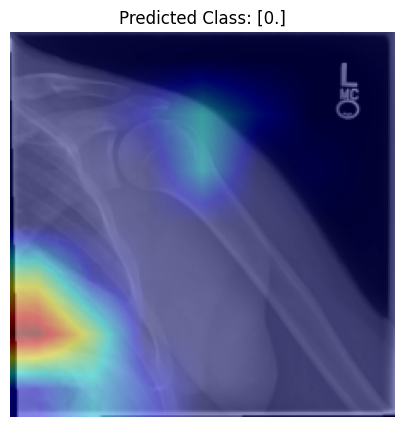

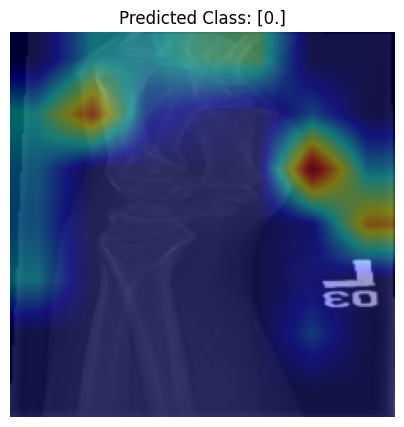

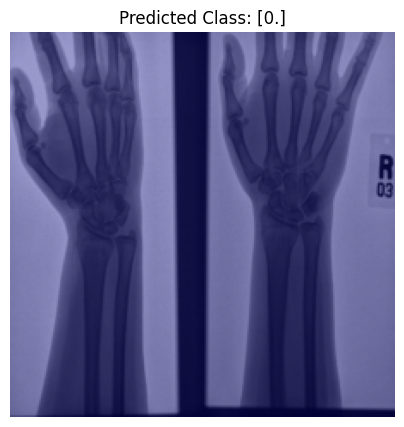

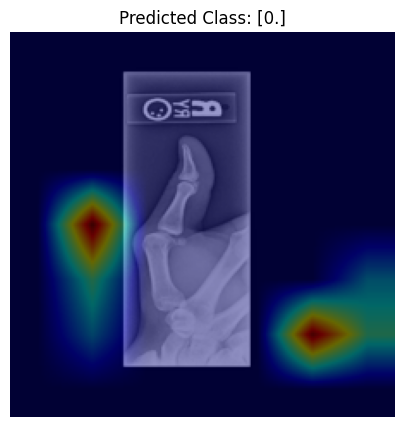

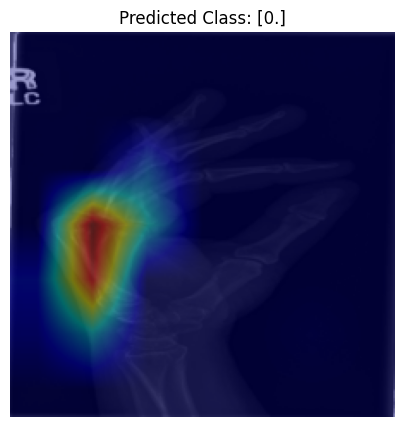

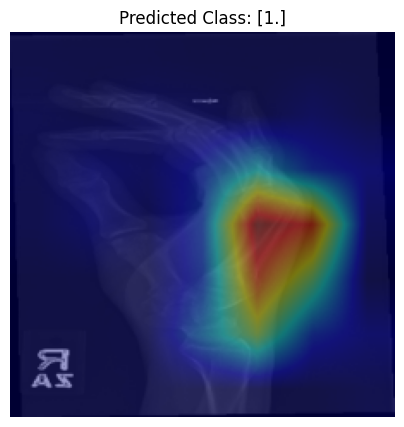

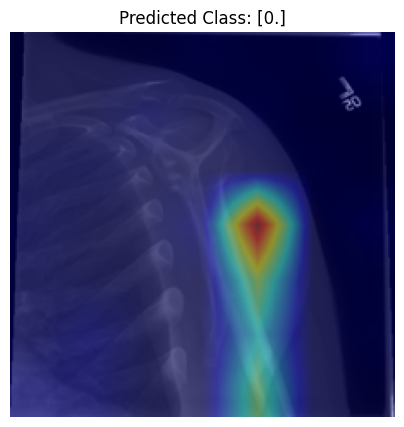

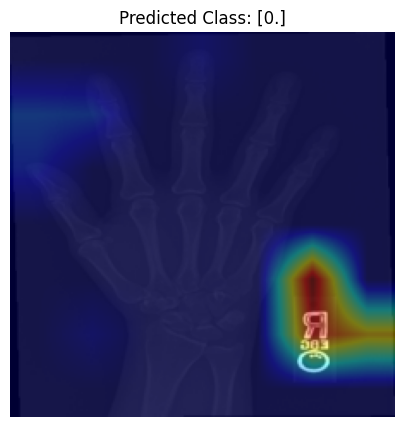

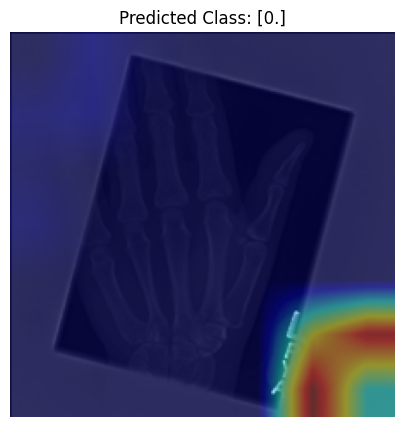

Visualizing Validation Dataset:


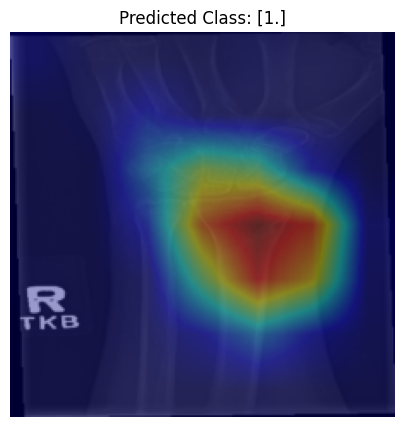

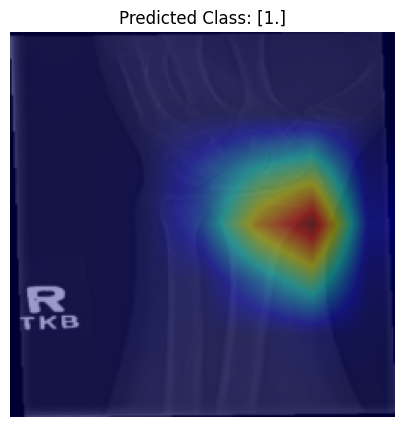

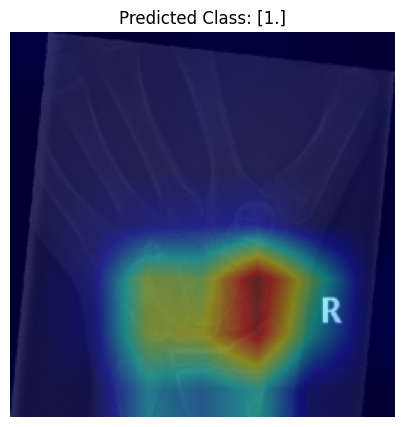

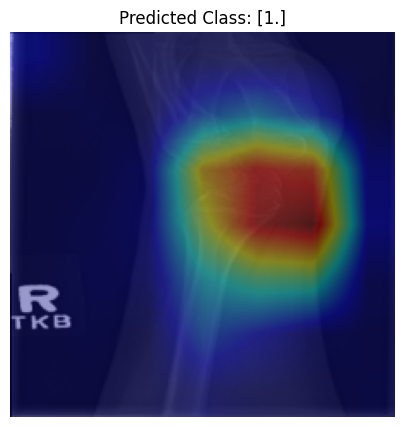

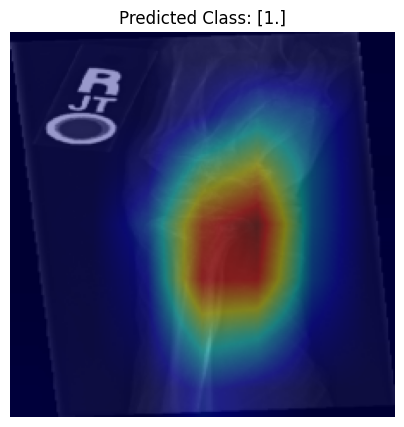

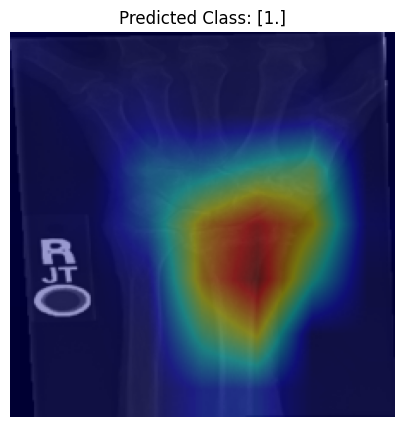

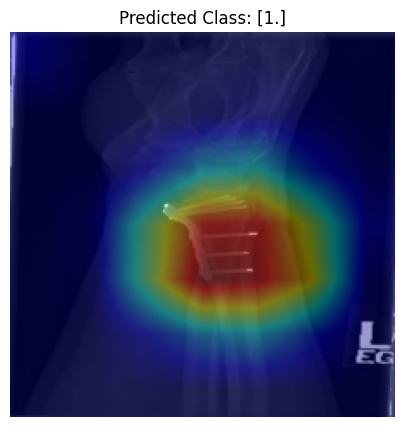

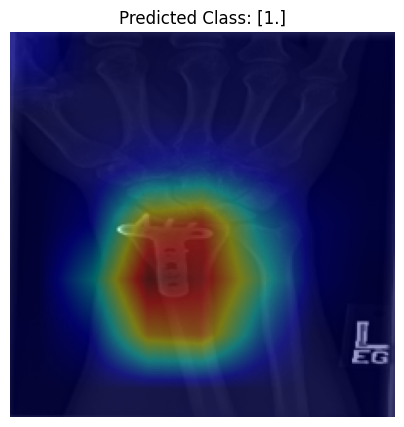

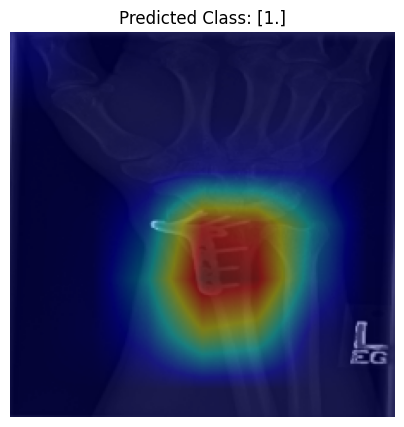

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
from PIL import Image
from torchvision import transforms

def compute_cam(model, img_tensor, layer_name="features.8"):
    model.eval()

    feature_maps = None
    def hook_fn(module, input, output):
        nonlocal feature_maps
        feature_maps = output

    # Hook into the specified layer
    layer = dict(model.named_modules())[layer_name]
    handle = layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        output = model(img_tensor)

    handle.remove()

    # Get predicted class for the entire batch
    predicted_classes = torch.round(torch.sigmoid(output)).cpu().numpy()

    # Initialize CAM for all images in the batch
    cams = []
    for i in range(predicted_classes.shape[0]):  # Iterate over the batch
        predicted_class = predicted_classes[i]

        # Get the weights from the final classifier layer
        weights = model.classifier[1].weight.detach().cpu().numpy().flatten()

        # Initialize the CAM with zeros
        cam = np.zeros(feature_maps.shape[2:], dtype=np.float32)

        # Compute the weighted sum of the feature maps
        for j in range(feature_maps.shape[1]):  # Iterate over channels
            cam += weights[j] * feature_maps[i, j].detach().cpu().numpy()

        # Normalize the CAM
        cam = np.maximum(cam, 0)
        cam = cam / np.max(cam)
        cam = np.uint8(255 * cam)
        cam = cv2.resize(cam, (224, 224))
        heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

        cams.append((heatmap, predicted_class))

    return cams



def visualize_images_with_cam(model, dataset_loader, device, num_images=9):
    model.eval()
    images_shown = 0

    # Iterate over the dataset
    for images, labels in dataset_loader:
        images, labels = images.to(device), labels.to(device)

        # Get CAMs and predicted classes for the batch
        cams = compute_cam(model, images)

        for i in range(len(cams)):
            cam, predicted_class = cams[i]

            # Convert the original image for visualization
            img = images[i].cpu().numpy().transpose((1, 2, 0))
            img = (img - img.min()) / (img.max() - img.min())  # Normalize image for display

            # Superimpose the CAM on the original image
            # Superimpose the CAM on the original image
            img = (img * 255).astype(np.uint8)  # Convert the normalized image back to uint8
            superimposed_img = cv2.addWeighted(img, 0.6, cam, 0.4, 0)

            # Display the image with CAM
            plt.figure(figsize=(5, 5))
            plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
            plt.title(f"Predicted Class: {predicted_class}")
            plt.axis("off")
            plt.show()

            images_shown += 1
            if images_shown >= num_images:
                return

# Visualize the first 9 images from the training dataset
print("Visualizing Training Dataset:")
visualize_images_with_cam(model, train_loader, device)

# Visualize the first 9 images from the validation dataset
print("Visualizing Validation Dataset:")
visualize_images_with_cam(model, valid_loader, device)


<ipython-input-9-68b51acc8daf>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_location=device))
/usr/local/lib/pyth

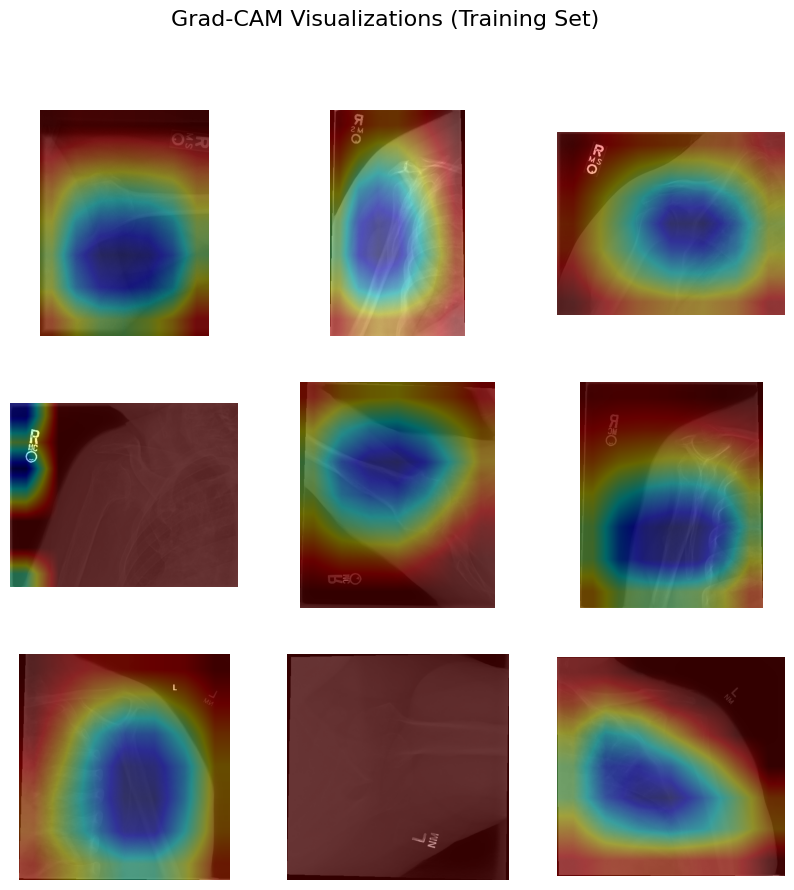

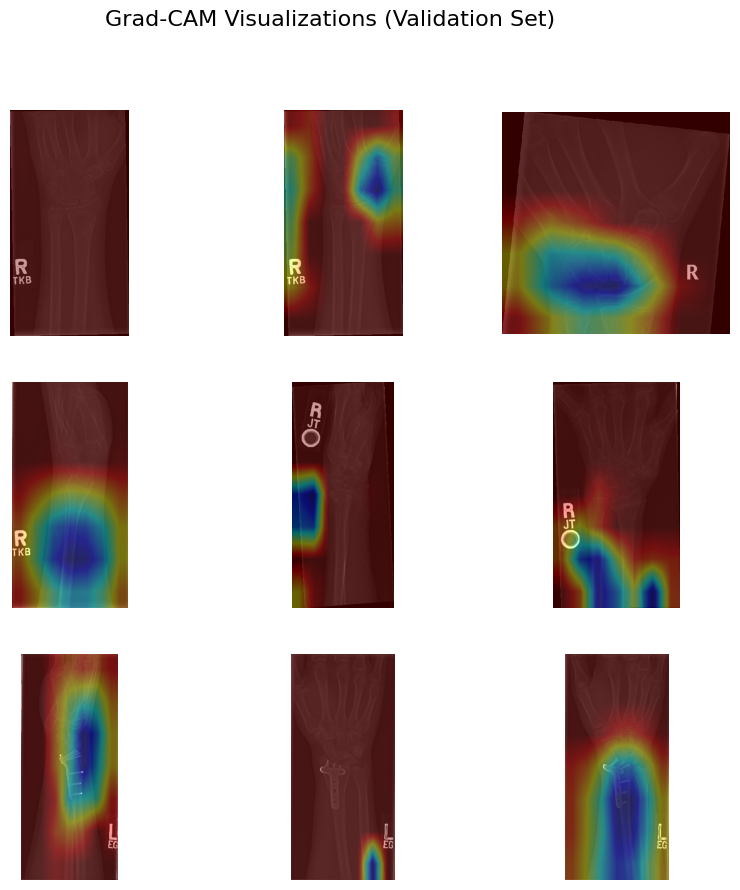

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
from torchvision import transforms
from PIL import Image

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(num_ftrs, 1)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()

# Grad-CAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self.forward_hook)
        self.target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output).item()

        self.model.zero_grad()
        output[:, class_idx].backward()

        gradients = self.gradients
        activations = self.activations

        alpha = gradients.mean(dim=[2, 3], keepdim=True)
        weighted_activations = alpha * activations
        heatmap = weighted_activations.sum(dim=1).squeeze()
        heatmap = F.relu(heatmap)

        heatmap -= heatmap.min()
        heatmap /= heatmap.max()
        return heatmap.cpu().detach().numpy()

# Image preprocessing
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(image).unsqueeze(0).to(device)

# Function to apply Grad-CAM to multiple images
def apply_gradcam_to_batch(images, dataset_name):
    target_layer = model.features[-1]  # Last conv layer
    gradcam = GradCAM(model, target_layer)

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))

    for i, (image, ax) in enumerate(zip(images, axes.flatten())):
        input_tensor = preprocess_image(image)
        heatmap = gradcam.generate_heatmap(input_tensor)

        heatmap = cv2.resize(heatmap, (image.size[0], image.size[1]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        img_cv = np.array(image)
        img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2BGR)
        overlayed_img = cv2.addWeighted(img_cv, 0.6, heatmap, 0.4, 0)

        ax.imshow(overlayed_img)
        ax.axis("off")

    plt.suptitle(f"Grad-CAM Visualizations ({dataset_name})", fontsize=16)
    plt.show()

# Extract first 9 images from datasets
train_images = [Image.open(train_dataset.df.iloc[i, 0]).convert("RGB") for i in range(9)]
valid_images = [Image.open(valid_dataset.df.iloc[i, 0]).convert("RGB") for i in range(9)]

# Apply Grad-CAM
apply_gradcam_to_batch(train_images, "Training Set")
apply_gradcam_to_batch(valid_images, "Validation Set")


In [ ]:
# Load the pre-trained model
model_state_dict = torch.load("/content/best_model.pth", map_location=torch.device('cpu'))
model = models.efficientnet_b3(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 1)
model.load_state_dict(model_state_dict)

device = torch.device("cpu")
model.to(device)

<ipython-input-17-e5b27b394b55>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load("/content/best_model.pth", map_location=torch.device('cpu'))
/

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
def compute_cam(model, img_tensor):
    model.eval()

    feature_maps = None
    def hook_fn(module, input, output):
        nonlocal feature_maps
        feature_maps = output

    # Hook into the specified layer
    layer = model.features[-1]
    handle = layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        output = model(img_tensor)

    handle.remove()

    # Get predicted class for the entire batch
    predicted_classes = torch.round(torch.sigmoid(output)).cpu().numpy()

    # Initialize CAM for all images in the batch
    cams = []
    for i in range(predicted_classes.shape[0]):  # Iterate over the batch
        predicted_class = predicted_classes[i]

        # Get the weights from the final classifier layer
        weights = model.classifier[1].weight.detach().cpu().numpy().flatten()

        # Initialize the CAM with zeros
        cam = np.zeros(feature_maps.shape[2:], dtype=np.float32)

        # Compute the weighted sum of the feature maps
        for j in range(feature_maps.shape[1]):  # Iterate over channels
            cam += weights[j] * feature_maps[i, j].detach().cpu().numpy()

        # Normalize the CAM
        cam = np.maximum(cam, 0)
        max_val = np.max(cam)
        if max_val != 0:
            cam = cam / max_val
        cam = np.uint8(255 * cam)
        cam = cv2.resize(cam, (224, 224))
        heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

        cams.append((heatmap, predicted_class))

    return cams


cams = []
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        cam = compute_cam(model, images)
        cams.extend(cam)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# U-Net Architecture
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        self.down1 = DoubleConv(in_channels, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)
        self.down5 = DoubleConv(512, 1024)

        self.pool = nn.MaxPool2d(2)

        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(1024, 512)

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(self.pool(x1))
        x3 = self.down3(self.pool(x2))
        x4 = self.down4(self.pool(x3))
        x5 = self.down5(self.pool(x4))

        x = self.up1(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.conv1(x)

        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.conv2(x)

        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.conv3(x)

        x = self.up4(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv4(x)

        x = torch.sigmoid(self.final_conv(x))  # Output should be in range [0,1]
        return x

# Custom Dataset for CAM Images
class CAMDataset(Dataset):
    def __init__(self, cam_images, transform=None):
        self.cam_images = cam_images
        self.transform = transform

    def __len__(self):
        return len(self.cam_images)

    def __getitem__(self, idx):
        cam, _ = self.cam_images[idx]  # Extract heatmap

        # Convert CAM to grayscale & normalize
        cam_gray = cv2.cvtColor(cam, cv2.COLOR_BGR2GRAY) / 255.0
        cam_tensor = torch.tensor(cam_gray, dtype=torch.float32).unsqueeze(0)  # Add channel dim

        # Convert CAM to binary mask (thresholded)
        label = (cam_gray > 0.5).astype(np.float32)
        label_tensor = torch.tensor(label, dtype=torch.float32).unsqueeze(0)

        if self.transform:
            cam_tensor = self.transform(cam_tensor)
            label_tensor = self.transform(label_tensor)

        return cam_tensor, label_tensor

# Generate CAM inputs from classifier
cams = []
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        cam_batch = compute_cam(model, images)  # Apply CAM
        cams.extend(cam_batch)  # Collect CAMs

# Convert CAMs into a dataset
cam_dataset = CAMDataset(cams, transform=transforms.Resize((128, 128)))
train_loader_unet = DataLoader(cam_dataset, batch_size=8, shuffle=True)

# Initialize U-Net model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet_model = UNet().to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(unet_model.parameters(), lr=0.001)

# Training Loop
num_epochs = 10
best_loss = float('inf')
best_model_state = None

for epoch in range(num_epochs):
    unet_model.train()
    epoch_loss = 0.0

    for cam_input, label in train_loader_unet:
        cam_input, label = cam_input.to(device), label.to(device)

        optimizer.zero_grad()
        output = unet_model(cam_input)

        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader_unet)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_state = unet_model.state_dict()

# Save trained U-Net model
torch.save(best_model_state, "best_autoLabelModel.pth")
print("U-Net training complete. Model saved!")


In [ ]:
# Load trained U-Net model
unet_model.load_state_dict(torch.load("best_autoLabelModel.pth"))
unet_model.eval()

# Predict on a test CAM image
test_cam_tensor = cam_dataset[0][0].unsqueeze(0).to(device)  # Single test image
with torch.no_grad():
    pred_mask = unet_model(test_cam_tensor)

# Convert prediction to numpy image
pred_mask = pred_mask.squeeze().cpu().numpy()
pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255  # Threshold to binary mask

# Show the predicted segmentation mask
import matplotlib.pyplot as plt
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")
plt.show()
